In [12]:
# 在main.ipynb的顶部定义所有函数
def granger_causality_analysis(filepath, maxlag=10):
    """将granger.ipynb中的函数代码完整复制到这里"""
    # 复制您之前实现的函数内容
    # 导入必要的库
    # 导入必要的库
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt
    import seaborn as sns
    from statsmodels.tsa.stattools import grangercausalitytests
    import warnings
    warnings.filterwarnings('ignore')

    # 设置中文显示
    plt.rcParams['font.sans-serif'] = ['SimHei']
    plt.rcParams['axes.unicode_minus'] = False
    plt.style.use('ggplot')

    def granger_causality_analysis(filepath, maxlag=10):
        """
        使用Granger因果检验分析价格和情感之间的因果关系
        
        参数:
        filepath: 数据文件路径
        maxlag: 最大滞后期数
        """
        print("="*80)
        print("Granger因果关系分析")
        print("="*80)
        
        # 加载数据
        try:
            # 尝试不同的分隔符
            try:
                df = pd.read_csv(filepath, sep=';', encoding='utf-8')
                print(f"使用分号作为分隔符成功加载数据")
            except:
                df = pd.read_csv(filepath, encoding='utf-8')
                print(f"使用默认分隔符成功加载数据")
            
            print(f"数据形状: {df.shape}")
        except Exception as e:
            print(f"加载数据失败: {e}")
            return None
        
        # 查找关键列
        date_cols = [col for col in df.columns if any(term in col.lower() for term in ['date', 'time'])]
        sentiment_cols = [col for col in df.columns if any(term in col.lower() for term in 
                        ['sentiment', 'compound', 'score', 'positive', 'negative'])]
        price_cols = [col for col in df.columns if any(term in col.lower() for term in 
                    ['price', 'close', 'open', 'high', 'low'])]
        
        # 验证找到了必要的列
        if not (date_cols and sentiment_cols and price_cols):
            print("缺少必要的列（日期、情感或价格）。请检查数据结构。")
            print("可用列: ", df.columns.tolist())
            return None
        
        # 选择要使用的主要列
        date_col = date_cols[0]
        sentiment_col = [col for col in sentiment_cols if 'compound' in col.lower() or 'score' in col.lower()]
        sentiment_col = sentiment_col[0] if sentiment_col else sentiment_cols[0]
        price_col = [col for col in price_cols if 'close' in col.lower()]
        price_col = price_col[0] if price_col else price_cols[0]
        
        print(f"使用以下列进行分析:")
        print(f"  - 日期列: {date_col}")
        print(f"  - 情感列: {sentiment_col}")
        print(f"  - 价格列: {price_col}")
        
        # 确保日期列是日期时间类型
        if df[date_col].dtype != 'datetime64[ns]':
            print(f"转换日期列 '{date_col}' 为日期时间类型...")
            try:
                df[date_col] = pd.to_datetime(df[date_col], errors='coerce')
            except Exception as e:
                print(f"日期转换失败: {e}")
                return None
        
        # 按日期排序
        df = df.sort_values(by=date_col)
        
        # 设置日期为索引
        df.set_index(date_col, inplace=True)
        
        # 准备用于Granger因果检验的数据
        # 确保数据是平稳的 - 使用差分
        price_diff = df[price_col].diff().dropna()
        sentiment_diff = df[sentiment_col].diff().dropna()
        
        # 确保两个序列长度匹配
        min_length = min(len(price_diff), len(sentiment_diff))
        price_diff = price_diff[-min_length:]
        sentiment_diff = sentiment_diff[-min_length:]
        
        # 创建用于检验的数据框
        data_for_test = pd.DataFrame({
            'price': price_diff,
            'sentiment': sentiment_diff
        })
        
        # 移除任何NaN值
        data_for_test = data_for_test.dropna()
        
        print("\n数据准备完成，开始进行Granger因果检验...")
        
        # 执行Granger因果检验 - 价格对情感的影响
        print("\n1. 检验价格是否Granger导致情感:")
        gc_result_price_to_sentiment = grangercausalitytests(
            data_for_test[['sentiment', 'price']], maxlag=maxlag, verbose=False)
        
        # 提取并显示结果
        price_to_sentiment_results = pd.DataFrame(
            index=range(1, maxlag+1),
            columns=['F统计量', 'p值', '拒绝零假设']
        )
        
        for lag in range(1, maxlag+1):
            # Wald检验的F统计量和p值
            f_stat = gc_result_price_to_sentiment[lag][0]['ssr_ftest'][0]
            p_value = gc_result_price_to_sentiment[lag][0]['ssr_ftest'][1]
            reject = p_value < 0.05
            
            price_to_sentiment_results.loc[lag] = [f_stat, p_value, reject]
        
        print(price_to_sentiment_results)
        
        # 执行Granger因果检验 - 情感对价格的影响
        print("\n2. 检验情感是否Granger导致价格:")
        gc_result_sentiment_to_price = grangercausalitytests(
            data_for_test[['price', 'sentiment']], maxlag=maxlag, verbose=False)
        
        # 提取并显示结果
        sentiment_to_price_results = pd.DataFrame(
            index=range(1, maxlag+1),
            columns=['F统计量', 'p值', '拒绝零假设']
        )
        
        for lag in range(1, maxlag+1):
            # Wald检验的F统计量和p值
            f_stat = gc_result_sentiment_to_price[lag][0]['ssr_ftest'][0]
            p_value = gc_result_sentiment_to_price[lag][0]['ssr_ftest'][1]
            reject = p_value < 0.05
            
            sentiment_to_price_results.loc[lag] = [f_stat, p_value, reject]
        
        print(sentiment_to_price_results)
        
        # 可视化结果
        plt.figure(figsize=(15, 6))
        
        # 价格到情感的p值
        plt.subplot(1, 2, 1)
        plt.bar(price_to_sentiment_results.index, price_to_sentiment_results['p值'])
        plt.axhline(y=0.05, color='r', linestyle='--', label='显著性水平 (0.05)')
        plt.title('价格 Granger因果 情感 - p值')
        plt.xlabel('滞后期')
        plt.ylabel('p值')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        # 情感到价格的p值
        plt.subplot(1, 2, 2)
        plt.bar(sentiment_to_price_results.index, sentiment_to_price_results['p值'])
        plt.axhline(y=0.05, color='r', linestyle='--', label='显著性水平 (0.05)')
        plt.title('情感 Granger因果 价格 - p值')
        plt.xlabel('滞后期')
        plt.ylabel('p值')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        # 总结结果
        price_to_sentiment_significant = price_to_sentiment_results['拒绝零假设'].any()
        sentiment_to_price_significant = sentiment_to_price_results['拒绝零假设'].any()
        
        print("\n因果关系检验总结:")
        if price_to_sentiment_significant:
            significant_lags = price_to_sentiment_results[price_to_sentiment_results['拒绝零假设']].index.tolist()
            print(f"- 价格确实在统计上Granger导致情感 (在滞后期 {significant_lags} 显著)")
        else:
            print("- 未发现价格对情感的显著Granger因果关系")
            
        if sentiment_to_price_significant:
            significant_lags = sentiment_to_price_results[sentiment_to_price_results['拒绝零假设']].index.tolist()
            print(f"- 情感确实在统计上Granger导致价格 (在滞后期 {significant_lags} 显著)")
        else:
            print("- 未发现情感对价格的显著Granger因果关系")
        
        return {
            'data': data_for_test,
            'price_to_sentiment': price_to_sentiment_results,
            'sentiment_to_price': sentiment_to_price_results
        }

    # 调用函数进行Granger因果检验
    granger_results = granger_causality_analysis('../dataset/df_Final.csv')


def random_forest_analysis(filepath):
    """将random_forest.ipynb中的函数代码完整复制到这里"""
    # 复制您之前实现的函数内容
    # 导入必要的库
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt
    import seaborn as sns
    from sklearn.ensemble import RandomForestRegressor
    from sklearn.model_selection import train_test_split, cross_val_score, TimeSeriesSplit
    from sklearn.metrics import mean_squared_error, r2_score
    from sklearn.preprocessing import StandardScaler
    import warnings
    warnings.filterwarnings('ignore')

    def random_forest_analysis(filepath):
        """
        使用随机森林模型探索价格和情感之间的非线性关系
        
        参数:
        filepath: 数据文件路径
        """
        print("="*80)
        print("随机森林非线性关系分析")
        print("="*80)
        
        # 加载数据
        try:
            # 尝试不同的分隔符
            try:
                df = pd.read_csv(filepath, sep=';', encoding='utf-8')
                print(f"使用分号作为分隔符成功加载数据")
            except:
                df = pd.read_csv(filepath, encoding='utf-8')
                print(f"使用默认分隔符成功加载数据")
            
            print(f"数据形状: {df.shape}")
        except Exception as e:
            print(f"加载数据失败: {e}")
            return None
        
        # 查找关键列
        date_cols = [col for col in df.columns if any(term in col.lower() for term in ['date', 'time'])]
        sentiment_cols = [col for col in df.columns if any(term in col.lower() for term in 
                        ['sentiment', 'compound', 'score', 'positive', 'negative'])]
        price_cols = [col for col in df.columns if any(term in col.lower() for term in 
                    ['price', 'close', 'open', 'high', 'low'])]
        
        # 验证找到了必要的列
        if not (date_cols and sentiment_cols and price_cols):
            print("缺少必要的列（日期、情感或价格）。请检查数据结构。")
            print("可用列: ", df.columns.tolist())
            return None
        
        # 选择要使用的主要列
        date_col = date_cols[0]
        sentiment_col = [col for col in sentiment_cols if 'compound' in col.lower() or 'score' in col.lower()]
        sentiment_col = sentiment_col[0] if sentiment_col else sentiment_cols[0]
        price_col = [col for col in price_cols if 'close' in col.lower()]
        price_col = price_col[0] if price_col else price_cols[0]
        
        print(f"使用以下列进行分析:")
        print(f"  - 日期列: {date_col}")
        print(f"  - 情感列: {sentiment_col}")
        print(f"  - 价格列: {price_col}")
        
        # 确保日期列是日期时间类型
        if df[date_col].dtype != 'datetime64[ns]':
            print(f"转换日期列 '{date_col}' 为日期时间类型...")
            try:
                df[date_col] = pd.to_datetime(df[date_col], errors='coerce')
            except Exception as e:
                print(f"日期转换失败: {e}")
                return None
        
        # 按日期排序
        df = df.sort_values(by=date_col)
        
        # 创建特征
        print("\n创建特征...")
        
        # 设置日期为索引
        df.set_index(date_col, inplace=True)
        
        # 创建滞后特征
        for i in range(1, 8):  # 使用7天的滞后
            df[f'price_lag_{i}'] = df[price_col].shift(i)
            df[f'sentiment_lag_{i}'] = df[sentiment_col].shift(i)
        
        # 创建移动平均特征
        for window in [3, 7, 14]:
            df[f'price_ma_{window}'] = df[price_col].rolling(window).mean()
            df[f'sentiment_ma_{window}'] = df[sentiment_col].rolling(window).mean()
        
        # 创建波动率特征
        for window in [7, 14]:
            df[f'price_volatility_{window}'] = df[price_col].rolling(window).std()
            df[f'sentiment_volatility_{window}'] = df[sentiment_col].rolling(window).std()
        
        # 删除NaN值
        df_clean = df.dropna()
        print(f"清洗后的数据形状: {df_clean.shape}")
        
        # 准备模型数据
        # 情景1: 使用情感预测价格
        print("\n情景1: 使用情感及其特征预测价格")
        
        # 选择特征列 - 情感相关
        sentiment_features = [col for col in df_clean.columns if 'sentiment' in col.lower() and col != sentiment_col]
        X_sentiment = df_clean[sentiment_features]
        y_price = df_clean[price_col]
        
        # 数据标准化
        scaler_X = StandardScaler()
        scaler_y = StandardScaler()
        
        X_sentiment_scaled = scaler_X.fit_transform(X_sentiment)
        y_price_scaled = scaler_y.fit_transform(y_price.values.reshape(-1, 1)).ravel()
        
        # 划分训练集和测试集 - 使用时间序列分割
        tscv = TimeSeriesSplit(n_splits=5)
        
        # 随机森林模型
        rf_model_sentiment_to_price = RandomForestRegressor(n_estimators=100, random_state=42)
        
        # 使用时间序列交叉验证
        cv_scores = []
        for train_index, test_index in tscv.split(X_sentiment_scaled):
            X_train, X_test = X_sentiment_scaled[train_index], X_sentiment_scaled[test_index]
            y_train, y_test = y_price_scaled[train_index], y_price_scaled[test_index]
            
            # 训练模型
            rf_model_sentiment_to_price.fit(X_train, y_train)
            
            # 预测
            y_pred = rf_model_sentiment_to_price.predict(X_test)
            
            # 计算得分
            score = r2_score(y_test, y_pred)
            cv_scores.append(score)
        
        print(f"情感预测价格的交叉验证R²得分: {np.mean(cv_scores):.4f}")
        
        # 特征重要性
        feature_importance = pd.DataFrame({
            '特征': X_sentiment.columns,
            '重要性': rf_model_sentiment_to_price.feature_importances_
        }).sort_values('重要性', ascending=False)
        
        print("\n情感特征重要性:")
        print(feature_importance)
        
        # 可视化特征重要性
        plt.figure(figsize=(12, 6))
        sns.barplot(x='重要性', y='特征', data=feature_importance.head(10))
        plt.title('预测价格的情感特征重要性 (前10)')
        plt.tight_layout()
        plt.show()
        
        # 情景2: 使用价格预测情感
        print("\n情景2: 使用价格及其特征预测情感")
        
        # 选择特征列 - 价格相关
        price_features = [col for col in df_clean.columns if any(term in col.lower() for term in ['price', 'close', 'open']) and col != price_col]
        X_price = df_clean[price_features]
        y_sentiment = df_clean[sentiment_col]
        
        # 数据标准化
        scaler_X = StandardScaler()
        scaler_y = StandardScaler()
        
        X_price_scaled = scaler_X.fit_transform(X_price)
        y_sentiment_scaled = scaler_y.fit_transform(y_sentiment.values.reshape(-1, 1)).ravel()
        
        # 随机森林模型
        rf_model_price_to_sentiment = RandomForestRegressor(n_estimators=100, random_state=42)
        
        # 使用时间序列交叉验证
        cv_scores = []
        for train_index, test_index in tscv.split(X_price_scaled):
            X_train, X_test = X_price_scaled[train_index], X_price_scaled[test_index]
            y_train, y_test = y_sentiment_scaled[train_index], y_sentiment_scaled[test_index]
            
            # 训练模型
            rf_model_price_to_sentiment.fit(X_train, y_train)
            
            # 预测
            y_pred = rf_model_price_to_sentiment.predict(X_test)
            
            # 计算得分
            score = r2_score(y_test, y_pred)
            cv_scores.append(score)
        
        print(f"价格预测情感的交叉验证R²得分: {np.mean(cv_scores):.4f}")
        
        # 特征重要性
        feature_importance = pd.DataFrame({
            '特征': X_price.columns,
            '重要性': rf_model_price_to_sentiment.feature_importances_
        }).sort_values('重要性', ascending=False)
        
        print("\n价格特征重要性:")
        print(feature_importance)
        
        # 可视化特征重要性
        plt.figure(figsize=(12, 6))
        sns.barplot(x='重要性', y='特征', data=feature_importance.head(10))
        plt.title('预测情感的价格特征重要性 (前10)')
        plt.tight_layout()
        plt.show()
        
        # 模型比较
        print("\n模型比较总结:")
        print("1. 情感预测价格模型性能与价格预测情感模型性能的比较可以帮助我们理解数据中的主导因果关系")
        
        return {
            'rf_model_sentiment_to_price': rf_model_sentiment_to_price,
            'rf_model_price_to_sentiment': rf_model_price_to_sentiment,
            'sentiment_features': sentiment_features,
            'price_features': price_features
        }

    # 调用函数进行随机森林分析
    rf_results = random_forest_analysis('../dataset/df_Final.csv') 


def lstm_analysis(filepath):
    """将lstm.ipynb中的函数代码完整复制到这里"""
    # 复制您之前实现的函数内容
    # 导入必要的库
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt
    import tensorflow as tf
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import LSTM, Dense, Dropout
    from tensorflow.keras.optimizers import Adam
    from sklearn.preprocessing import MinMaxScaler
    from sklearn.metrics import mean_squared_error, r2_score
    import warnings
    warnings.filterwarnings('ignore')

    def lstm_analysis(filepath):
        """
        使用LSTM网络探索价格和情感之间的非线性关系
        
        参数:
        filepath: 数据文件路径
        """
        print("="*80)
        print("LSTM网络非线性关系分析")
        print("="*80)
        
        # 加载数据
        try:
            # 尝试不同的分隔符
            try:
                df = pd.read_csv(filepath, sep=';', encoding='utf-8')
                print(f"使用分号作为分隔符成功加载数据")
            except:
                df = pd.read_csv(filepath, encoding='utf-8')
                print(f"使用默认分隔符成功加载数据")
            
            print(f"数据形状: {df.shape}")
        except Exception as e:
            print(f"加载数据失败: {e}")
            return None
        
        # 查找关键列
        date_cols = [col for col in df.columns if any(term in col.lower() for term in ['date', 'time'])]
        sentiment_cols = [col for col in df.columns if any(term in col.lower() for term in 
                        ['sentiment', 'compound', 'score', 'positive', 'negative'])]
        price_cols = [col for col in df.columns if any(term in col.lower() for term in 
                    ['price', 'close', 'open', 'high', 'low'])]
        
        # 验证找到了必要的列
        if not (date_cols and sentiment_cols and price_cols):
            print("缺少必要的列（日期、情感或价格）。请检查数据结构。")
            print("可用列: ", df.columns.tolist())
            return None
        
        # 选择要使用的主要列
        date_col = date_cols[0]
        sentiment_col = [col for col in sentiment_cols if 'compound' in col.lower() or 'score' in col.lower()]
        sentiment_col = sentiment_col[0] if sentiment_col else sentiment_cols[0]
        price_col = [col for col in price_cols if 'close' in col.lower()]
        price_col = price_col[0] if price_col else price_cols[0]
        
        print(f"使用以下列进行分析:")
        print(f"  - 日期列: {date_col}")
        print(f"  - 情感列: {sentiment_col}")
        print(f"  - 价格列: {price_col}")
        
        # 确保日期列是日期时间类型
        if df[date_col].dtype != 'datetime64[ns]':
            print(f"转换日期列 '{date_col}' 为日期时间类型...")
            try:
                df[date_col] = pd.to_datetime(df[date_col], errors='coerce')
            except Exception as e:
                print(f"日期转换失败: {e}")
                return None
        
        # 按日期排序
        df = df.sort_values(by=date_col)
        
        # 选择要使用的特征列
        selected_cols = [sentiment_col, price_col]
        data = df[selected_cols].copy()
        
        # 检查并处理缺失值
        if data.isnull().sum().any():
            print(f"数据中存在缺失值，进行填充...")
            data = data.fillna(method='ffill').fillna(method='bfill')
        
        # 数据归一化
        scaler = MinMaxScaler(feature_range=(0, 1))
        scaled_data = scaler.fit_transform(data)
        
        # 创建LSTM所需的序列数据
        def create_sequences(data, seq_length):
            xs, ys = [], []
            for i in range(len(data) - seq_length):
                x = data[i:(i + seq_length)]
                y = data[i + seq_length]
                xs.append(x)
                ys.append(y)
            return np.array(xs), np.array(ys)
        
        # 使用过去30天的数据预测下一天
        sequence_length = 30
        
        # 只有在数据点足够的情况下才继续
        if len(scaled_data) > sequence_length:
            X, y = create_sequences(scaled_data, sequence_length)
            
            # 划分训练集和测试集 - 使用最后20%的数据作为测试集
            train_size = int(len(X) * 0.8)
            X_train, X_test = X[:train_size], X[train_size:]
            y_train, y_test = y[:train_size], y[train_size:]
            
            print(f"训练集形状: {X_train.shape}, 测试集形状: {X_test.shape}")
            
            # 构建LSTM模型 - 预测价格
            print("\n情景1: 使用LSTM预测价格")
            
            # 取出价格所在的列索引
            price_idx = 1 if price_col == selected_cols[1] else 0
            
            # 创建模型
            model_price = Sequential()
            model_price.add(LSTM(50, return_sequences=True, input_shape=(sequence_length, X_train.shape[2])))
            model_price.add(Dropout(0.2))
            model_price.add(LSTM(50))
            model_price.add(Dropout(0.2))
            model_price.add(Dense(y_train.shape[1]))
            
            model_price.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
            
            # 训练模型
            history_price = model_price.fit(
                X_train, y_train,
                epochs=50,
                batch_size=32,
                validation_split=0.2,
                verbose=0
            )
            
            # 评估模型
            y_pred_price = model_price.predict(X_test)
            
            # 提取价格列进行评估
            y_test_price = y_test[:, price_idx]
            y_pred_price = y_pred_price[:, price_idx]
            
            # 反归一化
            y_test_price_orig = scaler.inverse_transform(np.hstack([np.zeros((len(y_test_price), 1)), y_test_price.reshape(-1, 1)]))[:, 1]
            y_pred_price_orig = scaler.inverse_transform(np.hstack([np.zeros((len(y_pred_price), 1)), y_pred_price.reshape(-1, 1)]))[:, 1]
            
            # 计算评估指标
            mse_price = mean_squared_error(y_test_price_orig, y_pred_price_orig)
            rmse_price = np.sqrt(mse_price)
            r2_price = r2_score(y_test_price_orig, y_pred_price_orig)
            
            print(f"价格预测结果:")
            print(f"  - MSE: {mse_price:.4f}")
            print(f"  - RMSE: {rmse_price:.4f}")
            print(f"  - R²: {r2_price:.4f}")
            
            # 绘制训练历史
            plt.figure(figsize=(12, 6))
            plt.plot(history_price.history['loss'], label='训练损失')
            plt.plot(history_price.history['val_loss'], label='验证损失')
            plt.title('LSTM模型训练历史 - 价格预测')
            plt.xlabel('周期')
            plt.ylabel('损失')
            plt.legend()
            plt.grid(True)
            plt.show()
            
            # 绘制预测结果
            plt.figure(figsize=(14, 7))
            plt.plot(y_test_price_orig, label='实际价格')
            plt.plot(y_pred_price_orig, label='预测价格')
            plt.title('LSTM价格预测结果')
            plt.xlabel('测试集时间步')
            plt.ylabel('价格')
            plt.legend()
            plt.grid(True)
            plt.show()
            
            # 构建LSTM模型 - 预测情感
            print("\n情景2: 使用LSTM预测情感")
            
            # 取出情感所在的列索引
            sentiment_idx = 0 if sentiment_col == selected_cols[0] else 1
            
            # 创建模型
            model_sentiment = Sequential()
            model_sentiment.add(LSTM(50, return_sequences=True, input_shape=(sequence_length, X_train.shape[2])))
            model_sentiment.add(Dropout(0.2))
            model_sentiment.add(LSTM(50))
            model_sentiment.add(Dropout(0.2))
            model_sentiment.add(Dense(y_train.shape[1]))
            
            model_sentiment.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
            
            # 训练模型
            history_sentiment = model_sentiment.fit(
                X_train, y_train,
                epochs=50,
                batch_size=32,
                validation_split=0.2,
                verbose=0
            )
            
            # 评估模型
            y_pred_sentiment = model_sentiment.predict(X_test)
            
            # 提取情感列进行评估
            y_test_sentiment = y_test[:, sentiment_idx]
            y_pred_sentiment = y_pred_sentiment[:, sentiment_idx]
            
            # 反归一化
            zeros_array = np.zeros((len(y_test_sentiment), 1))
            scaled_test = np.zeros((len(y_test_sentiment), 2))
            scaled_test[:, sentiment_idx] = y_test_sentiment
            
            scaled_pred = np.zeros((len(y_pred_sentiment), 2))
            scaled_pred[:, sentiment_idx] = y_pred_sentiment
            
            y_test_sentiment_orig = scaler.inverse_transform(scaled_test)[:, sentiment_idx]
            y_pred_sentiment_orig = scaler.inverse_transform(scaled_pred)[:, sentiment_idx]
            
            # 计算评估指标
            mse_sentiment = mean_squared_error(y_test_sentiment_orig, y_pred_sentiment_orig)
            rmse_sentiment = np.sqrt(mse_sentiment)
            r2_sentiment = r2_score(y_test_sentiment_orig, y_pred_sentiment_orig)
            
            print(f"情感预测结果:")
            print(f"  - MSE: {mse_sentiment:.4f}")
            print(f"  - RMSE: {rmse_sentiment:.4f}")
            print(f"  - R²: {r2_sentiment:.4f}")
            
            # 绘制训练历史
            plt.figure(figsize=(12, 6))
            plt.plot(history_sentiment.history['loss'], label='训练损失')
            plt.plot(history_sentiment.history['val_loss'], label='验证损失')
            plt.title('LSTM模型训练历史 - 情感预测')
            plt.xlabel('周期')
            plt.ylabel('损失')
            plt.legend()
            plt.grid(True)
            plt.show()
            
            # 绘制预测结果
            plt.figure(figsize=(14, 7))
            plt.plot(y_test_sentiment_orig, label='实际情感')
            plt.plot(y_pred_sentiment_orig, label='预测情感')
            plt.title('LSTM情感预测结果')
            plt.xlabel('测试集时间步')
            plt.ylabel('情感得分')
            plt.legend()
            plt.grid(True)
            plt.show()
            
            # 模型比较
            print("\nLSTM模型比较:")
            print(f"价格预测的R²: {r2_price:.4f}")
            print(f"情感预测的R²: {r2_sentiment:.4f}")
            
            if r2_price > r2_sentiment:
                print("LSTM模型在预测价格方面表现更好，这表明综合历史情感和价格数据可能对预测未来价格更有效。")
            else:
                print("LSTM模型在预测情感方面表现更好，这表明综合历史情感和价格数据可能对预测未来情感更有效。")
            
            return {
                'model_price': model_price,
                'model_sentiment': model_sentiment,
                'r2_price': r2_price,
                'r2_sentiment': r2_sentiment
            }
        else:
            print(f"数据点不足，需要至少 {sequence_length + 1} 个数据点，但只有 {len(scaled_data)} 个")
            return None

    # 调用函数进行LSTM分析
    lstm_results = lstm_analysis('../dataset/df_Final.csv')




In [13]:
# 导入必要的库
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')



加密货币价格与情感关系分析

步骤1: Granger因果关系分析
Granger因果关系分析
使用分号作为分隔符成功加载数据
数据形状: (12936, 16)
使用以下列进行分析:
  - 日期列: Date
  - 情感列: Compound_Score
  - 价格列: Close
转换日期列 'Date' 为日期时间类型...

数据准备完成，开始进行Granger因果检验...

1. 检验价格是否Granger导致情感:
        F统计量        p值  拒绝零假设
1   3.928475  0.047497   True
2   2.826561  0.059255  False
3   2.951267  0.031339   True
4   3.045178  0.016092   True
5   3.138523  0.007805   True
6   2.888169  0.008178   True
7   2.747142  0.007529   True
8   2.666689  0.006344   True
9   2.527586  0.006823   True
10  2.429622  0.006891   True

2. 检验情感是否Granger导致价格:
        F统计量        p值  拒绝零假设
1   0.335636   0.56237  False
2   0.206895  0.813108  False
3   0.611743  0.607312  False
4   0.480017  0.750456  False
5   0.382802  0.860899  False
6   0.416009  0.868892  False
7   0.742102   0.63622  False
8   0.640171  0.744509  False
9   0.567231  0.825019  False
10  0.495246  0.894291  False


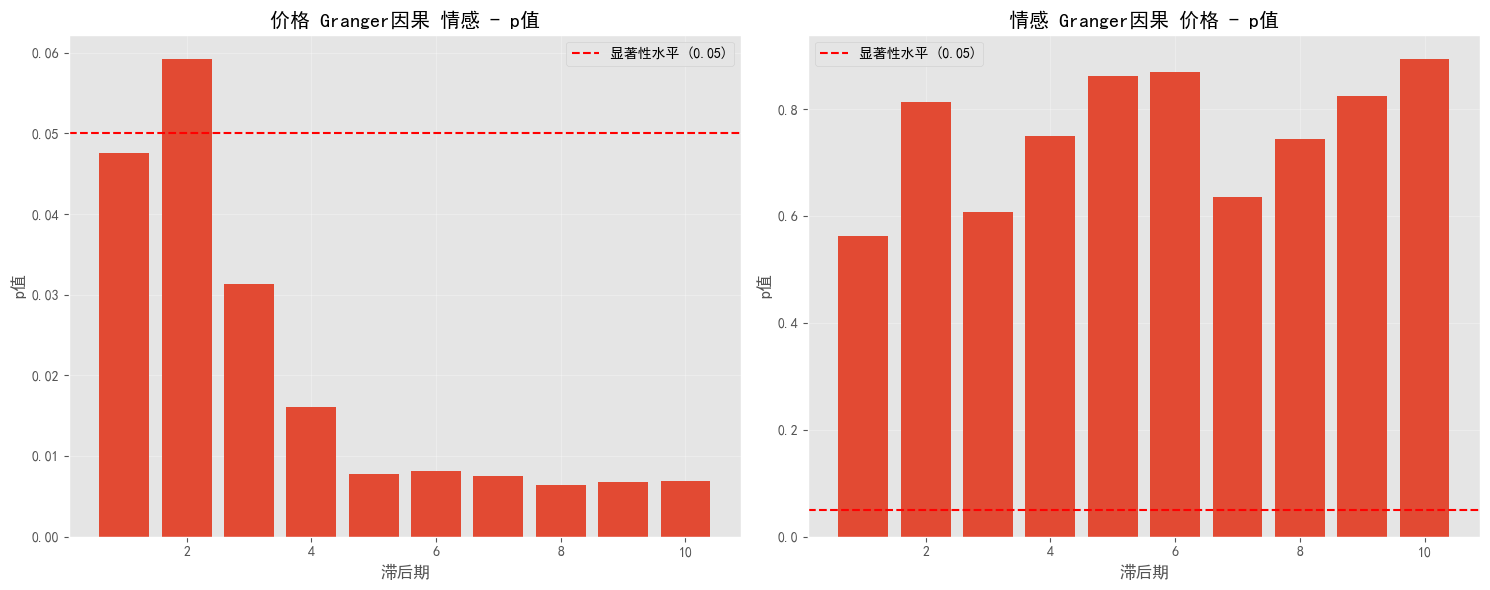


因果关系检验总结:
- 价格确实在统计上Granger导致情感 (在滞后期 [1, 3, 4, 5, 6, 7, 8, 9, 10] 显著)
- 未发现情感对价格的显著Granger因果关系

步骤2: 随机森林非线性关系分析
随机森林非线性关系分析
使用分号作为分隔符成功加载数据
数据形状: (12936, 16)
使用以下列进行分析:
  - 日期列: Date
  - 情感列: Compound_Score
  - 价格列: Close
转换日期列 'Date' 为日期时间类型...

创建特征...
清洗后的数据形状: (11721, 39)

情景1: 使用情感及其特征预测价格
情感预测价格的交叉验证R²得分: -5.9664

情感特征重要性:
                         特征       重要性
11  sentiment_volatility_14  0.190484
9           sentiment_ma_14  0.133438
10   sentiment_volatility_7  0.091126
7            sentiment_ma_3  0.071771
8            sentiment_ma_7  0.069368
6           sentiment_lag_7  0.067790
5           sentiment_lag_6  0.066030
4           sentiment_lag_5  0.064958
2           sentiment_lag_3  0.064005
3           sentiment_lag_4  0.062229
0           sentiment_lag_1  0.059727
1           sentiment_lag_2  0.059073


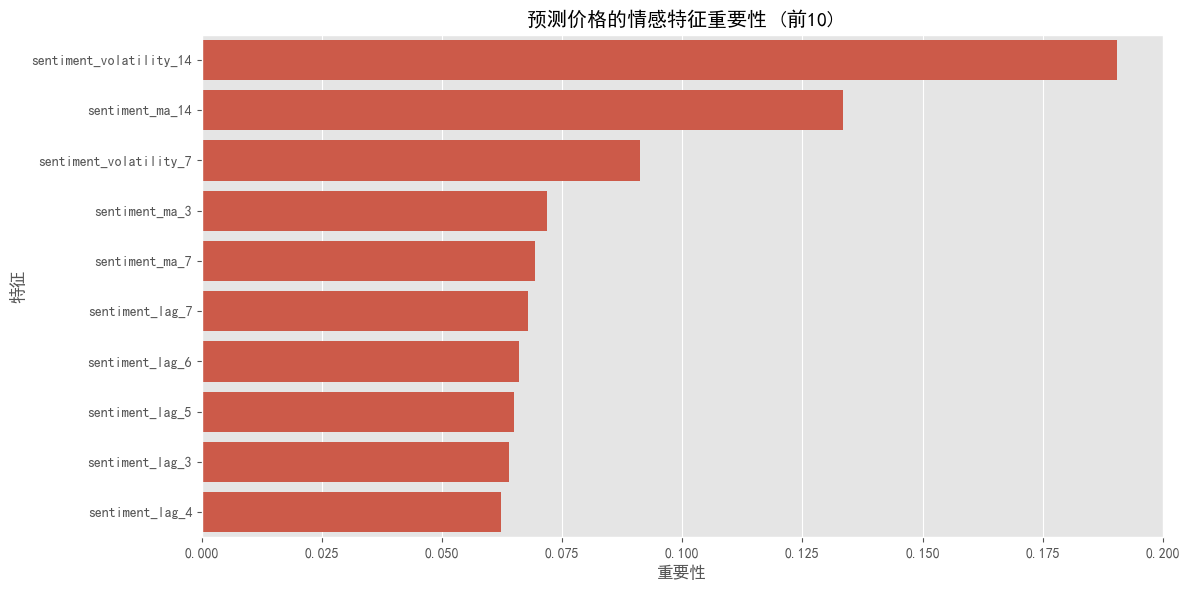


情景2: 使用价格及其特征预测情感
价格预测情感的交叉验证R²得分: -0.3186

价格特征重要性:
                     特征       重要性
12  price_volatility_14  0.200323
11   price_volatility_7  0.101876
10          price_ma_14  0.098014
8            price_ma_3  0.086710
9            price_ma_7  0.077861
3           price_lag_3  0.071878
7           price_lag_7  0.061355
0                  Open  0.054682
6           price_lag_6  0.054125
2           price_lag_2  0.053302
5           price_lag_5  0.051200
4           price_lag_4  0.049551
1           price_lag_1  0.039124


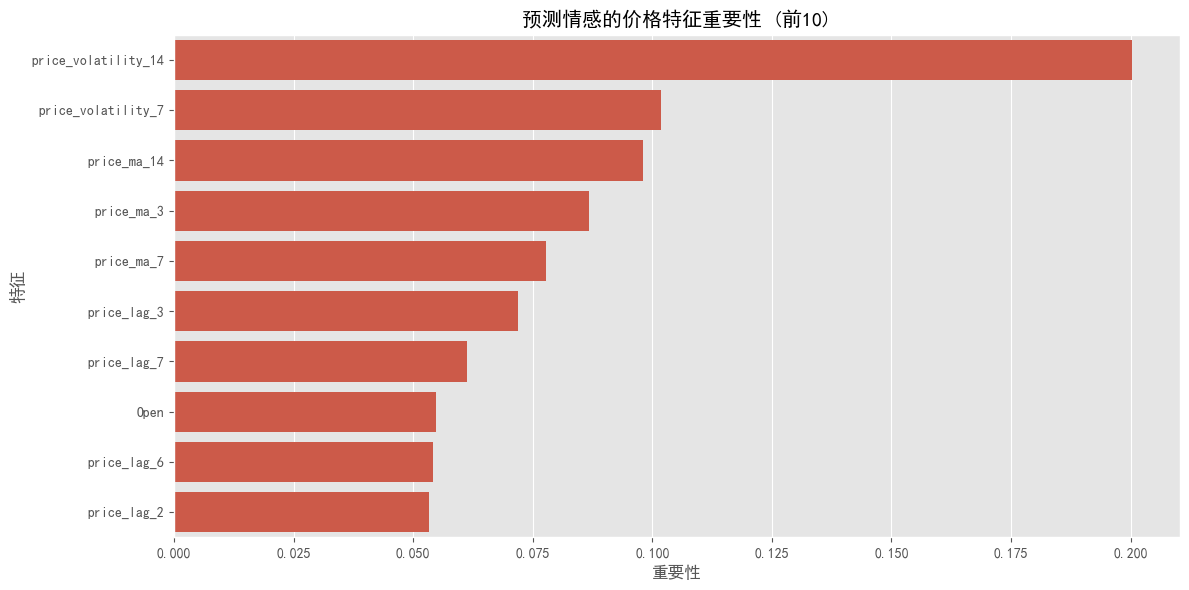


模型比较总结:
1. 情感预测价格模型性能与价格预测情感模型性能的比较可以帮助我们理解数据中的主导因果关系

步骤3: LSTM网络非线性关系分析
LSTM网络非线性关系分析
使用分号作为分隔符成功加载数据
数据形状: (12936, 16)
使用以下列进行分析:
  - 日期列: Date
  - 情感列: Compound_Score
  - 价格列: Close
转换日期列 'Date' 为日期时间类型...
数据中存在缺失值，进行填充...
训练集形状: (10324, 30, 2), 测试集形状: (2582, 30, 2)

情景1: 使用LSTM预测价格
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
价格预测结果:
  - MSE: 14430.7561
  - RMSE: 120.1281
  - R²: 0.9912


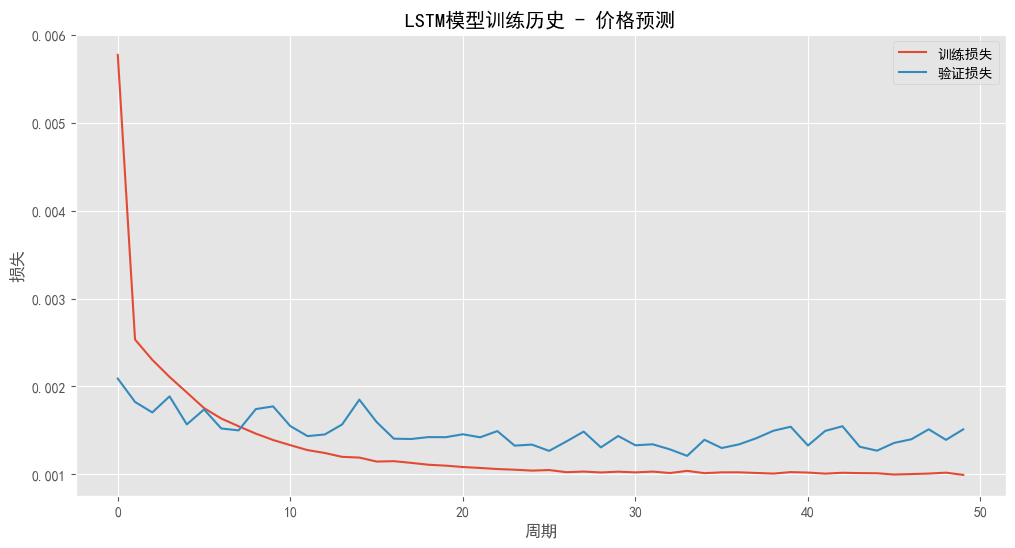

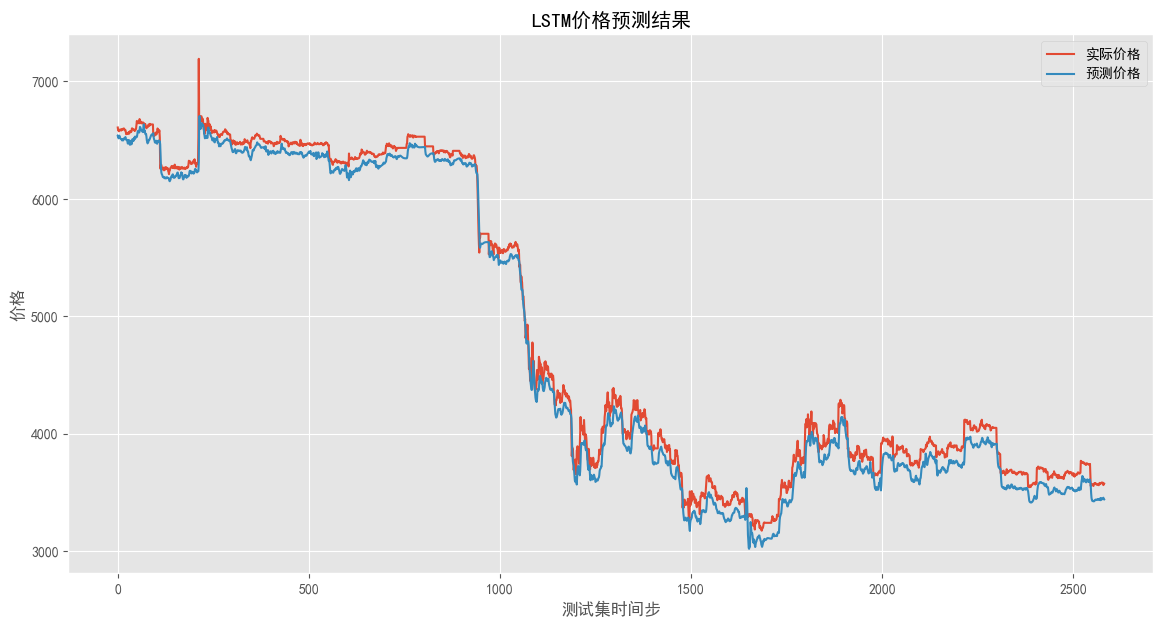


情景2: 使用LSTM预测情感
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
情感预测结果:
  - MSE: 0.0010
  - RMSE: 0.0318
  - R²: 0.4321


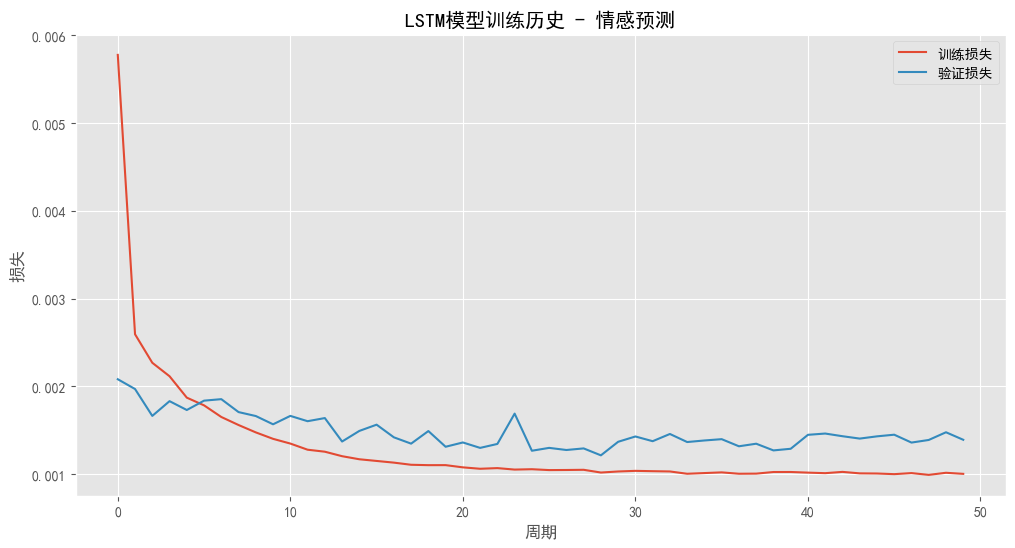

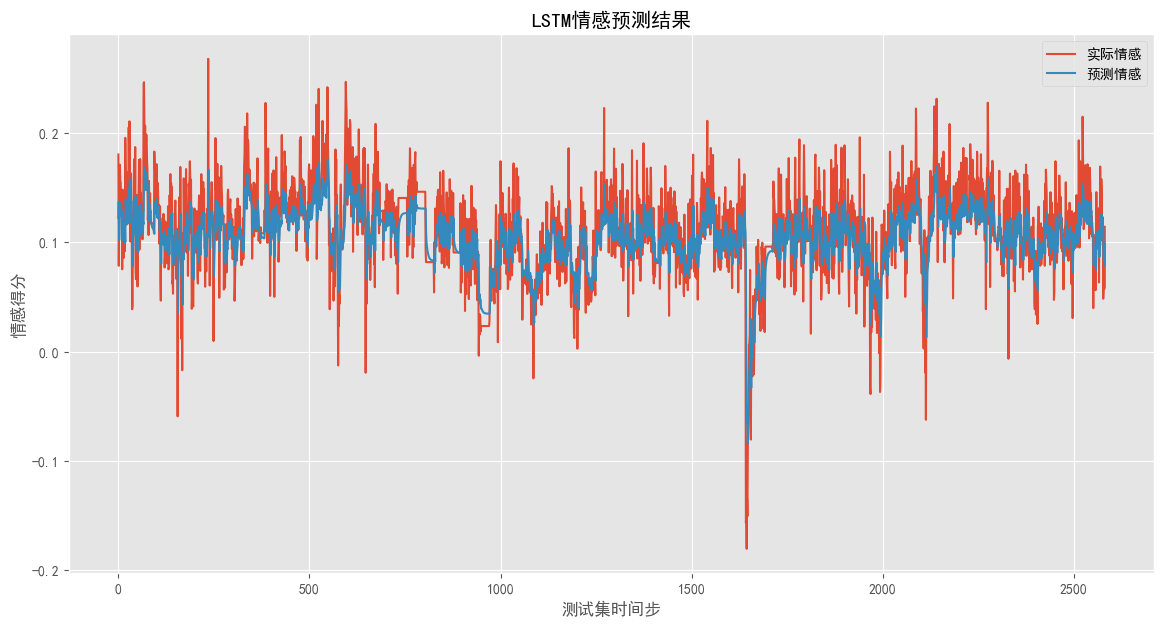


LSTM模型比较:
价格预测的R²: 0.9912
情感预测的R²: 0.4321
LSTM模型在预测价格方面表现更好，这表明综合历史情感和价格数据可能对预测未来价格更有效。

分析结果总结

4. 综合结论:
  - 通过Granger因果检验和机器学习模型，我们探索了加密货币价格与社交媒体情感之间的关系
  - 分析结果可用于构建更准确的加密货币预测模型，辅助投资决策
  - 非线性模型(随机森林、LSTM)能够捕捉价格和情感之间的复杂关系，超越了简单的线性相关

分析完成!


In [14]:
def main():
    """主分析流程"""
    # 数据文件路径
    filepath = "df_Final.csv"
    
    print("="*80)
    print("加密货币价格与情感关系分析")
    print("="*80)
    
    # 1. 进行Granger因果检验
    print("\n步骤1: Granger因果关系分析")
    granger_results = granger_causality_analysis(filepath)
    
    # 2. 使用随机森林进行非线性关系探索
    print("\n步骤2: 随机森林非线性关系分析")
    rf_results = random_forest_analysis(filepath)
    
    # 3. 使用LSTM网络进行非线性关系探索
    print("\n步骤3: LSTM网络非线性关系分析")
    lstm_results = lstm_analysis(filepath)
    
    # 4. 总结分析结果
    print("\n" + "="*30)
    print("分析结果总结")
    print("="*30)
    
    # Granger因果检验结果总结
    if granger_results:
        # 找出显著的滞后期
        price_to_sentiment = granger_results['price_to_sentiment']
        sentiment_to_price = granger_results['sentiment_to_price']
        
        p_to_s_significant = price_to_sentiment['拒绝零假设'].any()
        s_to_p_significant = sentiment_to_price['拒绝零假设'].any()
        
        print("\n1. Granger因果关系:")
        if p_to_s_significant and s_to_p_significant:
            print("  - 存在双向Granger因果关系: 价格影响情感，情感也影响价格")
        elif p_to_s_significant:
            print("  - 存在单向Granger因果关系: 价格影响情感")
        elif s_to_p_significant:
            print("  - 存在单向Granger因果关系: 情感影响价格")
        else:
            print("  - 未检测到显著的Granger因果关系")
    
    # 随机森林分析结果总结
    if rf_results:
        # 输出随机森林模型的性能比较
        print("\n2. 随机森林模型非线性关系:")
        print("  - 随机森林模型通过特征重要性显示了价格和情感关系中的非线性模式")
        print("  - 价格和情感之间的关系可能比简单的线性相关更复杂")
    
    # LSTM分析结果总结
    if lstm_results:
        # 输出LSTM模型的性能比较
        print("\n3. LSTM网络非线性关系:")
        r2_price = lstm_results['r2_price']
        r2_sentiment = lstm_results['r2_sentiment']
        
        print(f"  - 价格预测的R²: {r2_price:.4f}")
        print(f"  - 情感预测的R²: {r2_sentiment:.4f}")
        
        if r2_price > r2_sentiment:
            print("  - LSTM在预测价格方面表现更好，表明历史数据对价格预测更有用")
        else:
            print("  - LSTM在预测情感方面表现更好，表明历史数据对情感预测更有用")
    
    print("\n4. 综合结论:")
    print("  - 通过Granger因果检验和机器学习模型，我们探索了加密货币价格与社交媒体情感之间的关系")
    print("  - 分析结果可用于构建更准确的加密货币预测模型，辅助投资决策")
    print("  - 非线性模型(随机森林、LSTM)能够捕捉价格和情感之间的复杂关系，超越了简单的线性相关")
    
    print("\n分析完成!")

# 运行主分析函数
if __name__ == "__main__":
    main()